In [1]:
# this portion is done to ignore warnings from coffea for now
from __future__ import annotations

import os
import json
import time
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import parse
from atlas_schema.methods import behavior as as_behavior
from atlas_schema.schema import NtupleSchema
from coffea import processor
from coffea.analysis_tools import PackedSelection
from coffea.dataset_tools import apply_to_fileset
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from dask_jobqueue.htcondor import HTCondorCluster
from dask.distributed import LocalCluster
from matplotlib import pyplot as plt
import hist.dask as had

fname_pattern = parse.compile(
    "user.{username:w}.{dsid:d}.{process:S}.{campaign:w}.v{version:.1f}_ANALYSIS.root"
)

colors_dict = {
    "Znunu": "b",
    "Wenu": "g",
    "Wmunu": "r",
    "Wtaunu_L": "c",
    "Wtaunu_H": "m",
    "Znunugamma": "y",
    "Wmunugamma": "k",
    "Wenugamma": "brown",
    "Wtaunugamma": "pink",
    "N2_100_N1_97_WB_signal": "rosybrown",
    "Fake/Nonprompt": "lime",
}  #  'slategrey', 'blueviolet', 'crimson'


Giordon says to do this:

```
AB = (events.photon.pT > 10.0) & (abs(events.photon.eta) < 1.8)
photons_AB = events.photon[AB]
leading_photon = ak.firsts(photons_AB)
leading_photon_selected = leading_photon[(leading_photon.isolation == 1) & (leading_photon.tight == 1)]
```

In [2]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        
        self.h_ph_pt = (
            had.Hist.new.StrCat(["A_true","B_true","C_true","D_true",
                                 "A_fake","B_fake","C_fake","D_fake"], name="ABCD")
            .Regular(100, 0.0, 100.0, name="pt", label="$pt_{\\gamma}$ [GeV]")
            .Int64()
        )
        
        pass

    def process(self, events):
        ## TODO: remove this temporary fix when https://github.com/scikit-hep/vector/issues/498 is resolved
        met_dict = {field: events.met[field] for field in events.met.fields}
        met_dict["pt"] = dak.zeros_like(events.met.met)
        met_dict["eta"] = dak.zeros_like(events.met.met)
        events["met"] = dak.zip(met_dict, with_name="MissingET", behavior=as_behavior)

        dataset = events.metadata["dataset"]
        
        print(f"processing {len(events)} events for {dataset}")
        # xs = events.metadata["xs"]
        # lum = events.metadata["luminosity"]
        # process = events.metadata["process"]
        # genFiltEff = events.metadata["genFiltEff"]
        # evt_count = ak.num(events, axis=0).compute()
        # weights = (xs * genFiltEff * lum / evt_count) * np.ones(evt_count)

        leptons = ak.concatenate((events.el, events.mu), axis=1)

        # here are some selection cuts for something that looks like the signal region.
        # the only thing that's different is the MET requirement, which I inverted to be
        # met<250 instead of met>250, to make sure we don't accidentally unblind the SR
        # and to give us some more stats while we study MC samples.
        selections = {
            "met": events.met.met < 250 * 1.0e3,
            "lepton_veto": ak.num(leptons, axis=1) == 0,
            "leading_jet_pt": ak.firsts(events.jet.pt) > 100 * 1.0e3,
            "min_dphi_jet_met": ak.min(events.met.delta_phi(events.jet), axis=1) > 0.4,
            "bjet_veto": ak.sum(events.jet.btag_select, axis=1) == 0,
            "vgamma_overlap": events["in"][
                "vgamma_overlap_7"
            ],
        }
        
        selection = PackedSelection()
        selection.add_multiple(selections)

        SR=(selection.all())

        presel_events=events[SR]

        # photon object preselection
        ph_preselection = (
            (presel_events.ph.pt>10000) &
            (presel_events.ph.select_baseline==1) &
            ((presel_events.ph.isEM&0x45fc01)==0) &
            (
             (abs(presel_events.ph.eta)<1.37) | 
             ((abs(presel_events.ph.eta)>1.52) & 
              (abs(presel_events.ph.eta)<2.37))
            ) &
            (presel_events.ph.select_or_dR02Ph==1)
        )

        #AB = ph_preselection
        #photons_AB = events.ph[AB]
        #leading_photons = ak.firsts(photons_AB) # what is this?
        #leading_photon_selected = leading_photon[(leading_photon.isolation == 1) & (leading_photon.tight == 1)]

        ph_tight = (presel_events.ph[ph_preselection].select_tightID==1)
        ph_iso   = (presel_events.ph[ph_preselection].select_tightIso==1)
        ph_truth = ((presel_events.ph[ph_preselection].truthType != 0) & 
                    (presel_events.ph[ph_preselection].truthType != 16))

        # nothing works, and error messages are useless.
        #self.h_ph_pt.fill(ABCD="A_true", pt=ak.firsts(presel_events.ph[ph_preselection & ph_tight & ~ph_iso &  ph_truth].pt) / 1.0e3)
        #self.h_ph_pt.fill(ABCD="B_true", pt=events[SR & ~ph_tight & ~ph_iso &  ph_truth].ph.pt / 1.0e3)
        #self.h_ph_pt.fill(ABCD="C_true", pt=events[SR &  ph_tight &  ph_iso &  ph_truth].ph.pt / 1.0e3)
        #self.h_ph_pt.fill(ABCD="D_true", pt=events[SR & ~ph_tight &  ph_iso &  ph_truth].ph.pt / 1.0e3)

        #self.h_ph_pt.fill(ABCD="A_fake", pt=events[SR &  ph_tight & ~ph_iso & ~ph_truth].ph.pt / 1.0e3)
        #self.h_ph_pt.fill(ABCD="B_fake", pt=events[SR & ~ph_tight & ~ph_iso & ~ph_truth].ph.pt / 1.0e3)
        #self.h_ph_pt.fill(ABCD="C_fake", pt=events[SR &  ph_tight &  ph_iso & ~ph_truth].ph.pt / 1.0e3)
        #self.h_ph_pt.fill(ABCD="D_fake", pt=events[SR & ~ph_tight &  ph_iso & ~ph_truth].ph.pt / 1.0e3)

        return {
            dataset: {
                "entries": ak.num(events, axis=0),
                "ph_pt": self.h_ph_pt,
            }
        }

    def postprocess(self, accumulator):
        pass

In [3]:
start_time = time.time()

my_processor = MyProcessor()

# load in a bunch of datasets
#dataset_runnable = json.loads(Path("af_v2.json").read_text())
dataset_runnable = json.loads(Path("af_v2_onefile.json").read_text())

cluster=None
dataset_to_run=None

can_submit_to_condor=False
datasettag='Znunugamma'

if can_submit_to_condor:
    # To facilitate usage with HTCondor
    cluster = HTCondorCluster(
        log_directory=Path().cwd() / ".condor_logs" / "cutflows_v2",
        cores=4,
        memory="4GB",
        disk="2GB",
    )
    cluster.scale(jobs=100)

    # if we're running over all samples, ensure that here
    dataset_to_run=dataset_runnable
else:
    cluster=LocalCluster()
    dataset_to_run={datasettag: dataset_runnable[datasettag]}


client = Client(cluster)

print("Applying to fileset")
out = apply_to_fileset(
    my_processor,
    dataset_to_run,
    schemaclass=NtupleSchema,
)

print("Beginning of dask.compute()")

# Add progress bar for dask
pbar = ProgressBar()
pbar.register()

(computed,) = dask.compute(out)
end_time = time.time()

print("Execution time: ", end_time - start_time)
print("Finished dask.compute")
print(computed)

/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44105 instead
  warnings.warn(


Applying to fileset


/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/atlas_schema/schema.py:70: RuntimeWarning: Missing event_ids : ['dataTakingYear', 'lumiBlock', 'mcEventWeights']
  self._form["fields"], self._form["contents"] = self._build_collections(


processing 872532 events for Znunugamma
Beginning of dask.compute()
Execution time:  2.8384811878204346
Finished dask.compute
{'Znunugamma': {'Znunugamma': {'entries': 872532, 'ph_pt': Hist(
  StrCategory(['A_true', 'B_true', 'C_true', 'D_true', 'A_fake', 'B_fake', 'C_fake', 'D_fake'], name='ABCD'),
  Regular(100, 0, 100, name='pt', label='$pt_{\\gamma}$ [GeV]'),
  storage=Int64())}}}


/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/mhance/.pixi/envs/default/lib/python3.12/site-packages/mplhep/utils.py:481: RuntimeWarning: All sumw are zero!

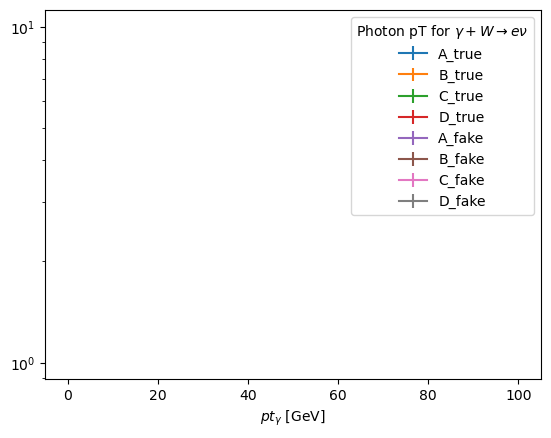

In [4]:
# Plot histograms
fig, ax = plt.subplots()
computed[datasettag][datasettag]["ph_pt"].plot1d(ax=ax)
ax.set_yscale("log")
ax.legend(title="Photon pT for $\\gamma + W\\rightarrow e \\nu$")